In [1]:
import pyanitools as pyt
import aniensemblestats as aes
import pyaniasetools as aat

import hdnntools as hdt

import pandas as pd
import numpy as np

import matplotlib
import matplotlib as mpl
from matplotlib import gridspec 
import matplotlib.pyplot as plt

import os

van Der Waals correction will be unavailable. Please install ased3


In [2]:
def generate_errors(cns, sae, nnf, Nn):
    # Set NC
    aens = aat.anicrossvalidationconformer(cns, sae, nnf, Nn, [1])

    Eerrors = []
    Ferrors = []

    per_net_Eerrors = {}
    per_net_Ferrors = {}

    atme = []
    for i in range(Nn):
        print('Network:',i)

        #adl = pyt.anidataloader('/home/jujuman/Scratch/Research/data000.h5')
        #adl = pyt.anidataloader('/home/jujuman/Scratch/Research/qm9/train_hcno/all_h5files/ANI-1x-CHNO_small_all.h5')


        adl = pyt.anidataloader(ensemble_dir + 'testset/testset'+str(i)+'.h5')

        Eqmt = []
        Eait = []

        Fqmt = []
        Fait = []

        N = 0
        for data in adl:
            X = data['coordinates']
            S = data['species']
            Eqm = hdt.hatokcal*data['energies']
            Fqm = hdt.hatokcal*data['forces']
            #print(data['solvent'])

            N += Eqm.size

            Esae = hdt.compute_sae(sae,S)

            atme.append((Eqm/hdt.hatokcal)-Esae)

            idx = np.where((Eqm/hdt.hatokcal)-Esae < 10000.0)[0]

            X = X[idx]
            Eqm = Eqm [idx]
            Fqm = Fqm [idx]

            if np.where((Eqm/hdt.hatokcal)-Esae > 1.0)[0].size > 0:
                print('HIGH E',np.where((Eqm/hdt.hatokcal)-Esae > 1.0))

            if Eqm.size > 0:

                Eai,Fai = aens.compute_energy_conformations_net(X=X,S=S,netid=i)

                Eqmt.append(Eqm-hdt.hatokcal*Esae)
                Eait.append(Eai-hdt.hatokcal*Esae)

                Fqmt.append(Fqm.flatten())
                Fait.append(Fai.flatten())

        Eqmt = np.concatenate(Eqmt)
        Eait = np.concatenate(Eait)

        Fqmt = np.concatenate(Fqmt)
        Fait = np.concatenate(Fait)

        per_net_Eerrors.update({"network-"+str(i):np.stack([Eqmt,Eait])})
        per_net_Ferrors.update({"network-"+str(i):np.stack([Fqmt,Fait])})

        Eerrors.append(np.array([hdt.calculatemeanabserror(Eqmt,Eait),
                                hdt.calculaterootmeansqrerror(Eqmt,Eait)]))

        Ferrors.append(np.array([hdt.calculatemeanabserror(Fqmt,Fait),
                                hdt.calculaterootmeansqrerror(Fqmt,Fait)]))
        print(Eerrors[-1])
        print(Ferrors[-1])

    Eerrors = np.stack(Eerrors)
    Ferrors = np.stack(Ferrors)
    return Eerrors,Ferrors,per_net_Eerrors,per_net_Ferrors

In [3]:
ensemble_dir = '/home/jujuman/Scratch/Research/new_mvcc_data/14e_test/model_ani14e_e14_E-2/'

cns = ensemble_dir + 'rHBCNOSiPSFAsSeClBrI-5.2R_8-3.6A_a4-2.params'
sae = ensemble_dir + 'sae_linfit.dat'
nnf = ensemble_dir + 'train'
Nn = 8

Eerrors, Ferrors, per_net_Eerrors, per_net_Ferrors = generate_errors(cns, sae, nnf, Nn)

Network: 0
[3.25225928 4.61571226]
[ 7.647605 12.208529]
Network: 1
[3.32010556 4.66192078]
[ 7.9524674 12.646631 ]
Network: 2
[3.33308984 4.76534984]
[ 7.8838396 12.623981 ]
Network: 3
[3.30584455 4.6683706 ]
[ 8.017853 12.705573]
Network: 4
[3.28644028 4.64318399]
[ 7.7937856 12.382845 ]
Network: 5
[3.30571449 4.75191468]
[ 7.957716  12.5953865]
Network: 6
[3.32869372 4.72178757]
[ 7.9020677 12.526033 ]
Network: 7
[3.29286299 4.69993322]
[ 7.940035 12.610848]


In [4]:
print('Force Training')
print('Energy error:')
print(pd.DataFrame(np.vstack([Eerrors,np.mean(Eerrors,axis=0)])))
print('Force error:')
print(pd.DataFrame(np.vstack([Ferrors,np.mean(Ferrors,axis=0)])))

Force Training
Energy error:
     0    1
0 3.25 4.62
1 3.32 4.66
2 3.33 4.77
3 3.31 4.67
4 3.29 4.64
5 3.31 4.75
6 3.33 4.72
7 3.29 4.70
8 3.30 4.69
Force error:
     0     1
0 7.65 12.21
1 7.95 12.65
2 7.88 12.62
3 8.02 12.71
4 7.79 12.38
5 7.96 12.60
6 7.90 12.53
7 7.94 12.61
8 7.89 12.54


In [6]:
ensemble_dir = '/home/jujuman/Scratch/Research/new_mvcc_data/14e_test/model_ani14e_e14_EF-2/'

cns = ensemble_dir + 'rHBCNOSiPSFAsSeClBrI-5.2R_16-3.6A_a4-4.params'
sae = ensemble_dir + 'sae_linfit.dat'
nnf = ensemble_dir + 'train'
Nn = 8

Eerrors_noforce, Ferrors_noforce, per_net_Eerrors_EF, per_net_Ferrors_EF = generate_errors(cns, sae, nnf, Nn)

Network: 0
[1.98998444 2.98555484]
[3.023676 5.045146]
Network: 1
[1.94420713 2.89042848]
[2.9730835 4.954732 ]
Network: 2
[1.93322922 2.89529966]
[2.9582505 4.926323 ]
Network: 3
[1.95051438 2.90534519]
[2.9849713 4.958089 ]
Network: 4
[1.94431108 3.07214217]
[2.9402752 4.8859286]
Network: 5
[1.97015838 2.9107822 ]
[2.9789016 4.9541154]
Network: 6
[1.97941957 2.99547612]
[3.0124192 5.0192494]
Network: 7
[2.0390754  2.99015552]
[3.121825  5.1943393]


In [7]:
print('Energy Only Training')
print('Energy error:')
print(pd.DataFrame(np.vstack([Eerrors_noforce,np.mean(Eerrors_noforce,axis=0)])))
print('Force error:')
print(pd.DataFrame(np.vstack([Ferrors_noforce,np.mean(Ferrors_noforce,axis=0)])))

Energy Only Training
Energy error:
     0    1
0 1.99 2.99
1 1.94 2.89
2 1.93 2.90
3 1.95 2.91
4 1.94 3.07
5 1.97 2.91
6 1.98 3.00
7 2.04 2.99
8 1.97 2.96
Force error:
     0    1
0 3.02 5.05
1 2.97 4.95
2 2.96 4.93
3 2.98 4.96
4 2.94 4.89
5 2.98 4.95
6 3.01 5.02
7 3.12 5.19
8 3.00 4.99


In [8]:
Ee = np.vstack([Eerrors_noforce,np.mean(Eerrors_noforce,axis=0)])
Ef = np.vstack([Eerrors,np.mean(Eerrors,axis=0)])
Eerr = np.hstack([Ee,Ef])

Fe = np.vstack([Ferrors_noforce,np.mean(Ferrors_noforce,axis=0)])
Ff = np.vstack([Ferrors,np.mean(Ferrors,axis=0)])
Ferr = np.hstack([Fe,Ff])


In [9]:
print('Energy Errors kcal/mol')
pd.DataFrame({'ET MAE':Eerr[:,0],'ET RMSE':Eerr[:,1],'FT MAE':Eerr[:,2],'FT RMSE':Eerr[:,3]})

Energy Errors kcal/mol


,ET MAE,ET RMSE,FT MAE,FT RMSE
0,1.99,2.99,3.25,4.62
1,1.94,2.89,3.32,4.66
2,1.93,2.90,3.33,4.77
3,1.95,2.91,3.31,4.67
4,1.94,3.07,3.29,4.64
5,1.97,2.91,3.31,4.75
6,1.98,3.00,3.33,4.72
7,2.04,2.99,3.29,4.70
8,1.97,2.96,3.30,4.69


In [10]:
print('Force Errors kcal/mol/A')
pd.DataFrame({'ET MAE':Ferr[:,0],'ET RMSE':Ferr[:,1],'FT MAE':Ferr[:,2],'FT RMSE':Ferr[:,3]})

Force Errors kcal/mol/A


,ET MAE,ET RMSE,FT MAE,FT RMSE
0,3.02,5.05,7.65,12.21
1,2.97,4.95,7.95,12.65
2,2.96,4.93,7.88,12.62
3,2.98,4.96,8.02,12.71
4,2.94,4.89,7.79,12.38
5,2.98,4.95,7.96,12.60
6,3.01,5.02,7.90,12.53
7,3.12,5.19,7.94,12.61
8,3.00,4.99,7.89,12.54


In [12]:
from anitraintools import plot_corr_dist_ax

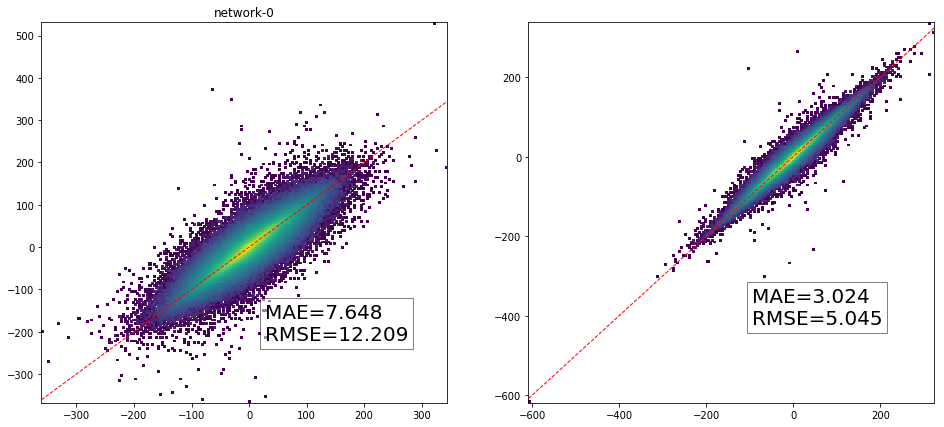

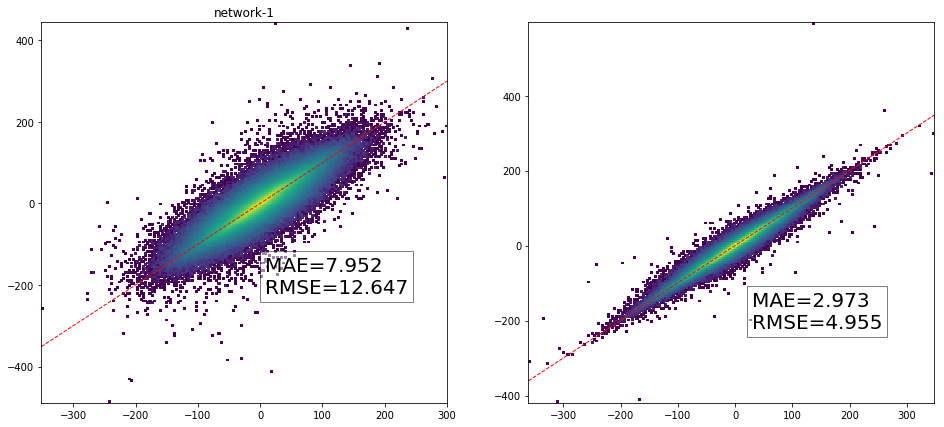

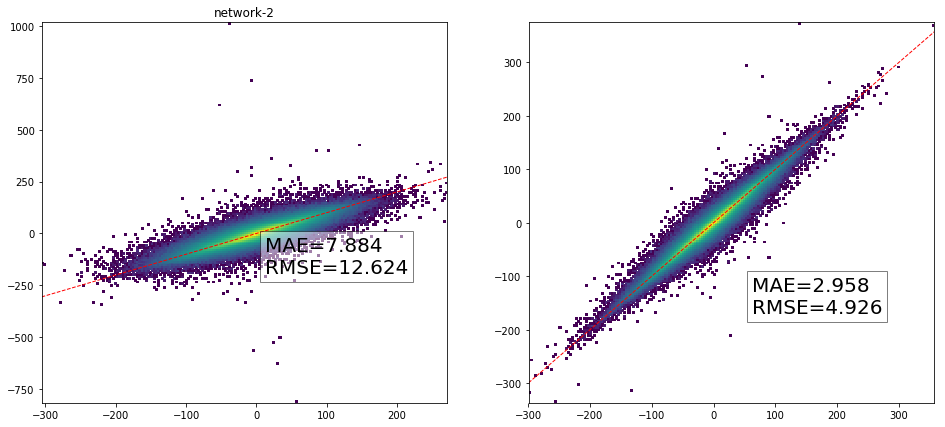

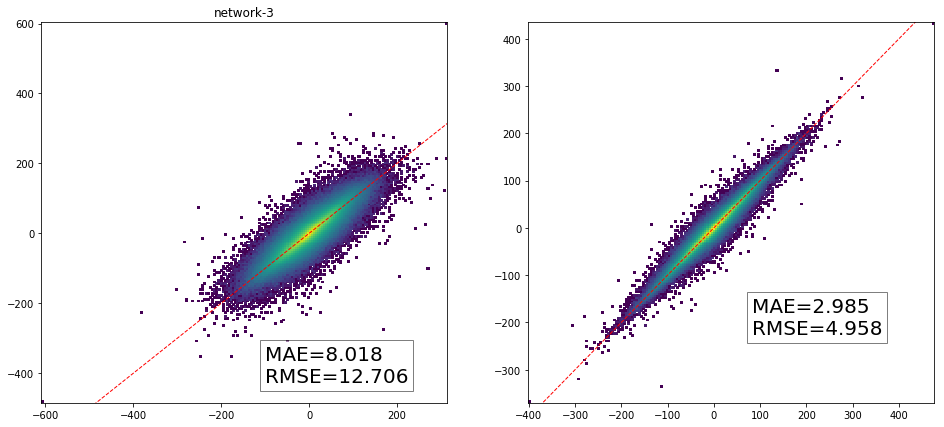

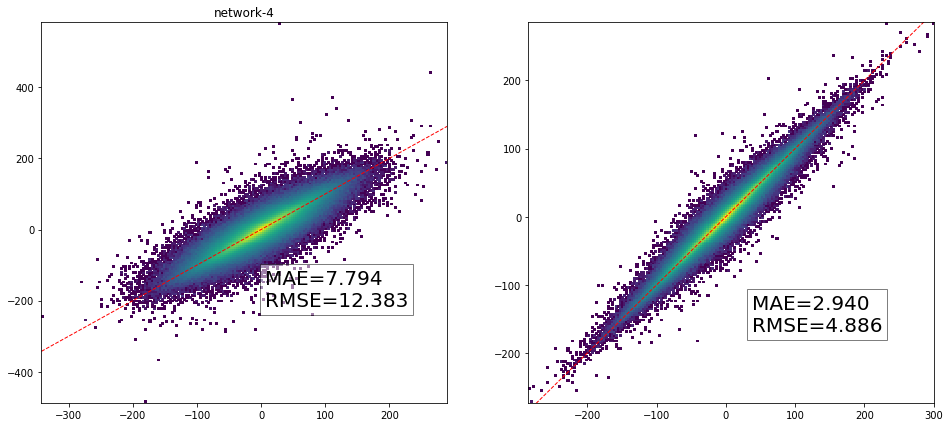

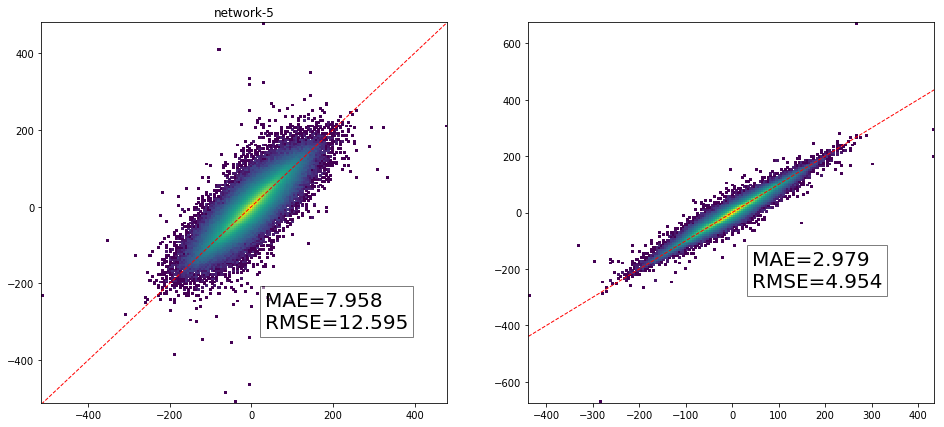

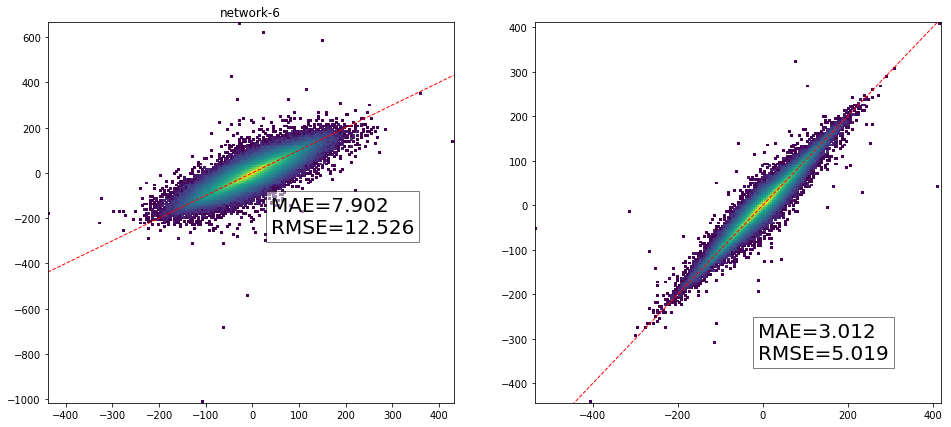

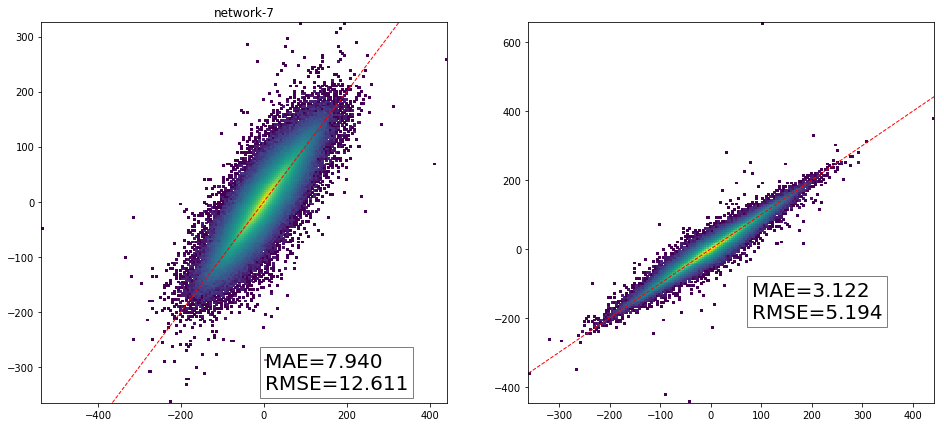

In [21]:
for key in per_net_Ferrors.keys():
    fig, ax = plt.subplots(1,2,figsize=(16,7))
    ax[0].set_title(key)
    plot_corr_dist_ax(ax[0],per_net_Ferrors[key][0],per_net_Ferrors[key][1],errors=True)
    plot_corr_dist_ax(ax[1],per_net_Ferrors_EF[key][0],per_net_Ferrors_EF[key][1],errors=True)
    plt.show()

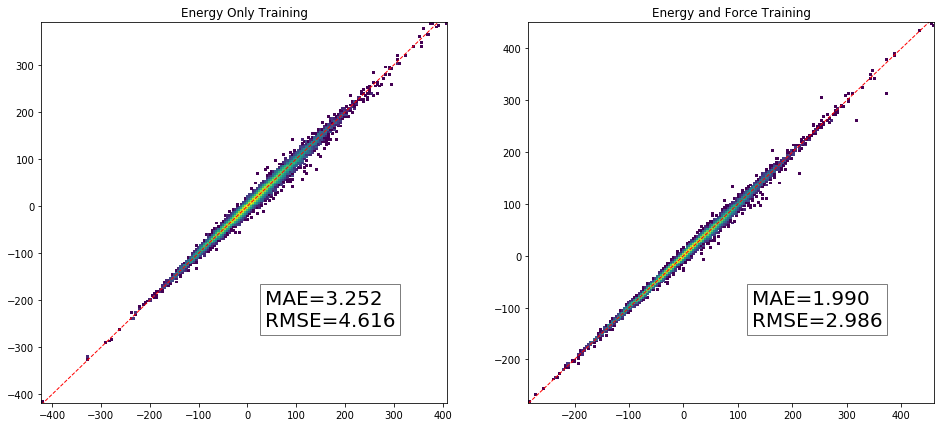

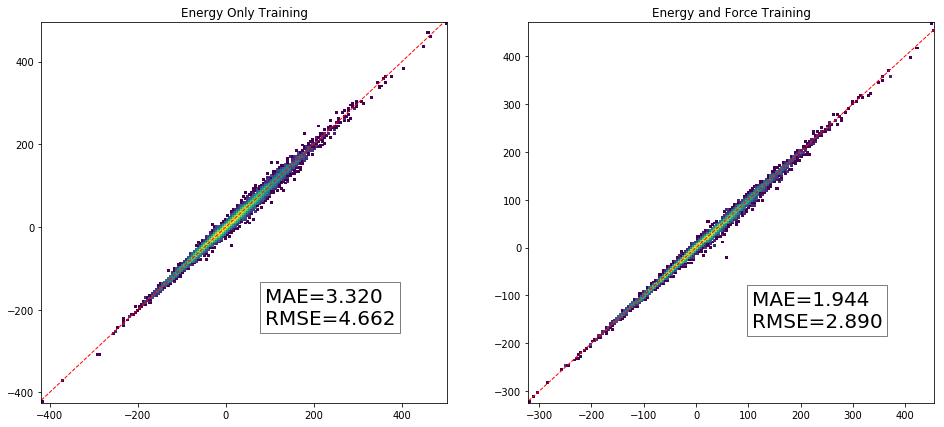

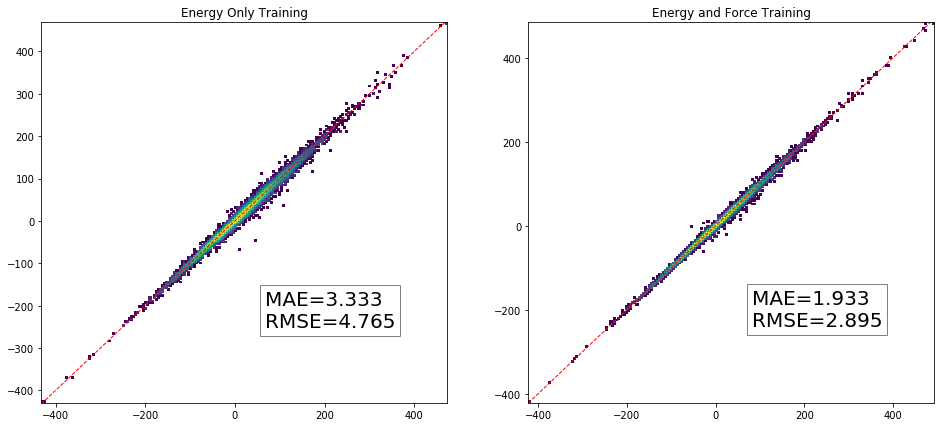

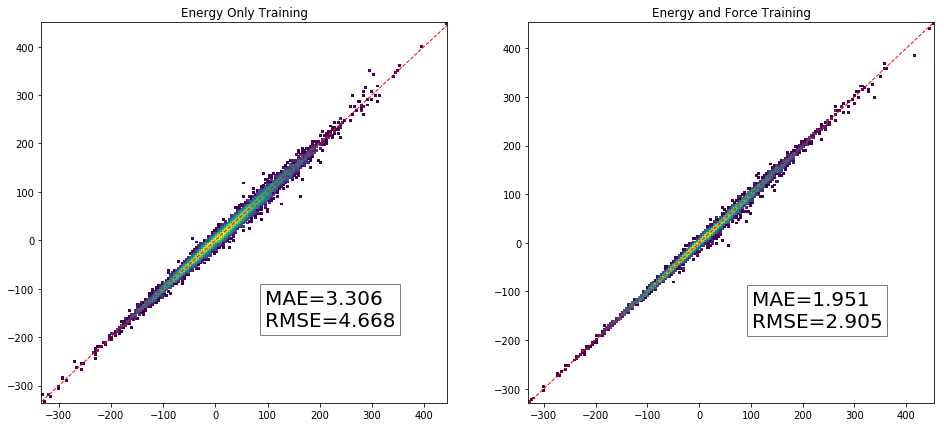

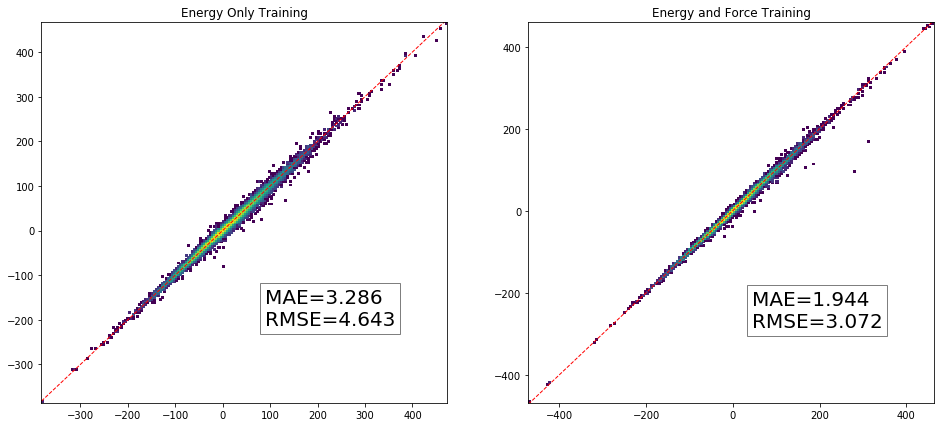

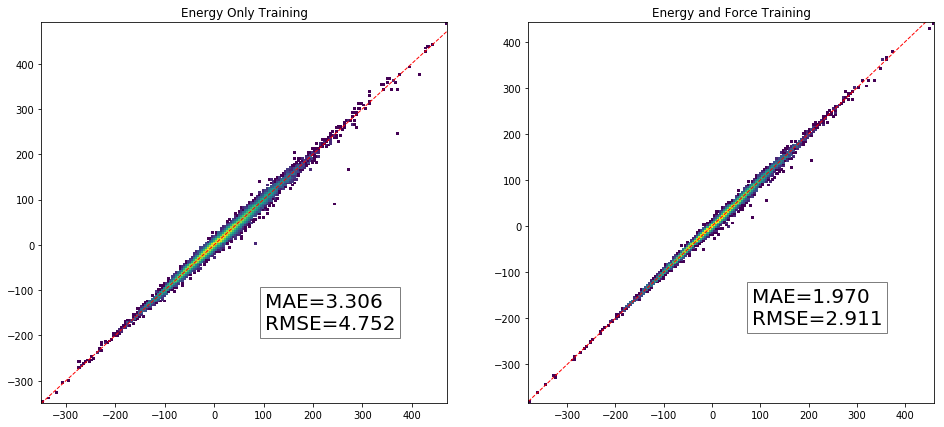

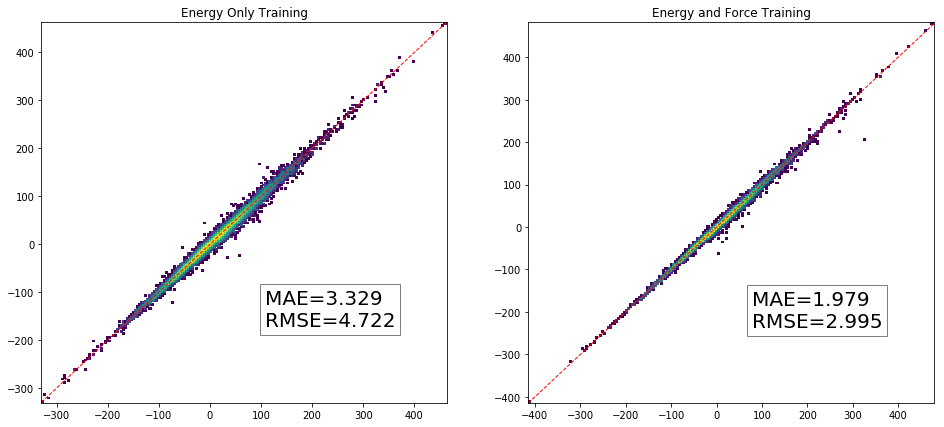

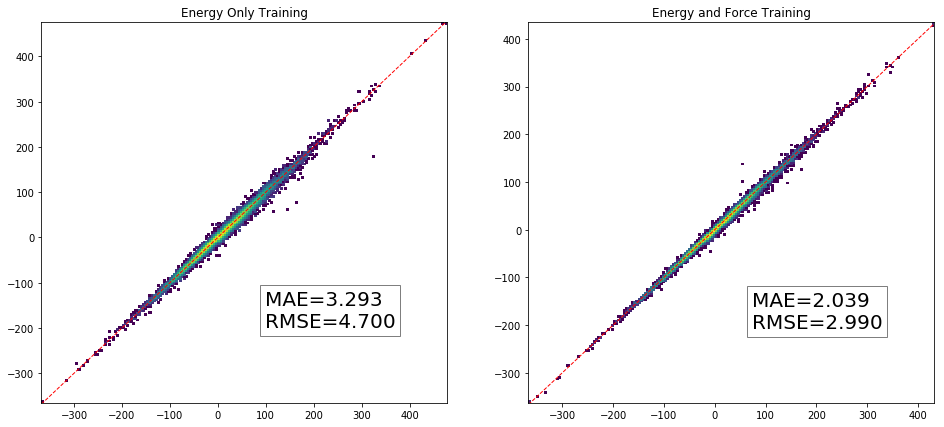

In [25]:
for key in per_net_Eerrors.keys():
    fig, ax = plt.subplots(1,2,figsize=(16,7))
    ax[0].set_title("Energy Only Training")
    plot_corr_dist_ax(ax[0],per_net_Eerrors[key][0],per_net_Eerrors[key][1],errors=True)
    
    ax[1].set_title("Energy and Force Training")
    plot_corr_dist_ax(ax[1],per_net_Eerrors_EF[key][0],per_net_Eerrors_EF[key][1],errors=True)
    plt.show()

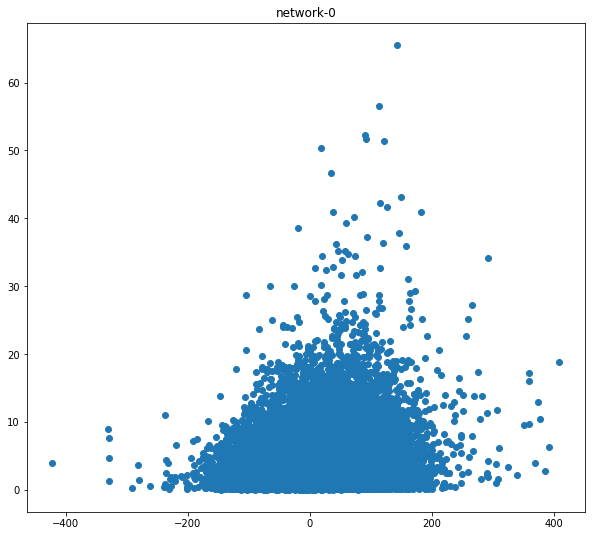

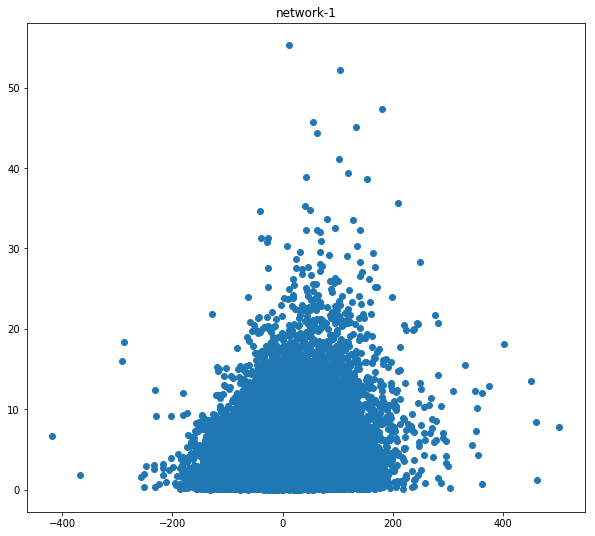

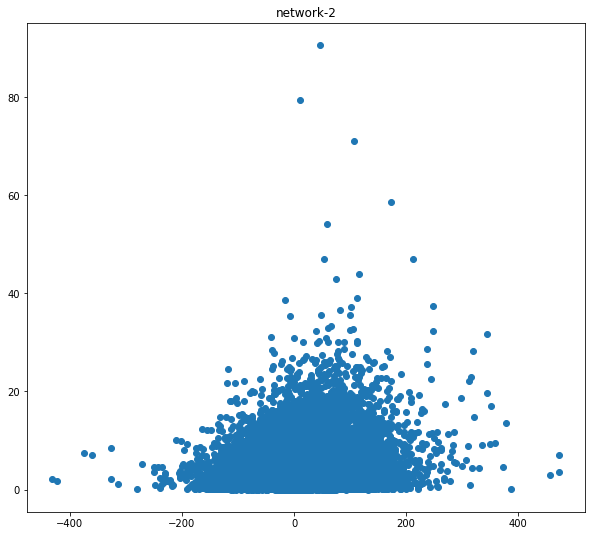

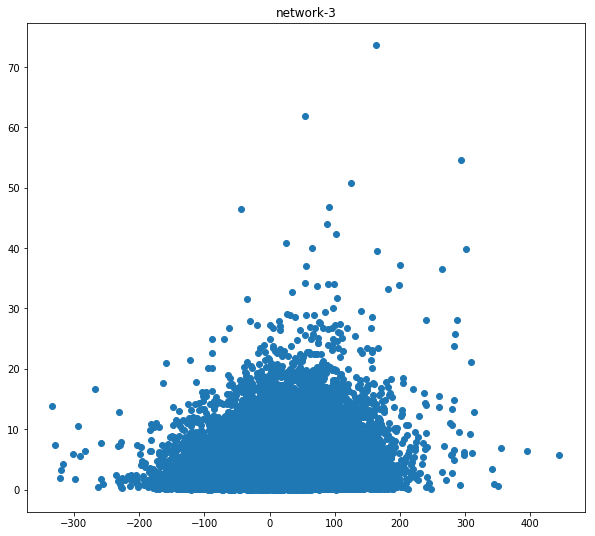

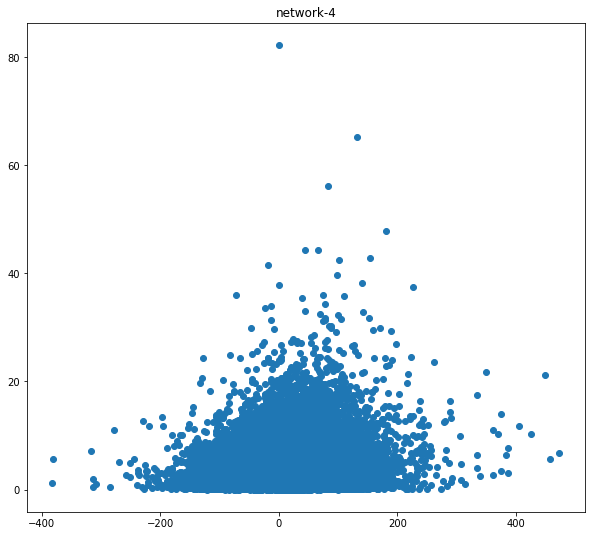

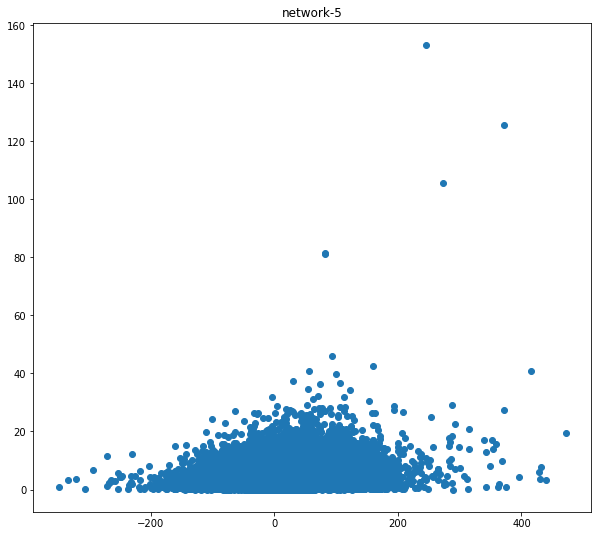

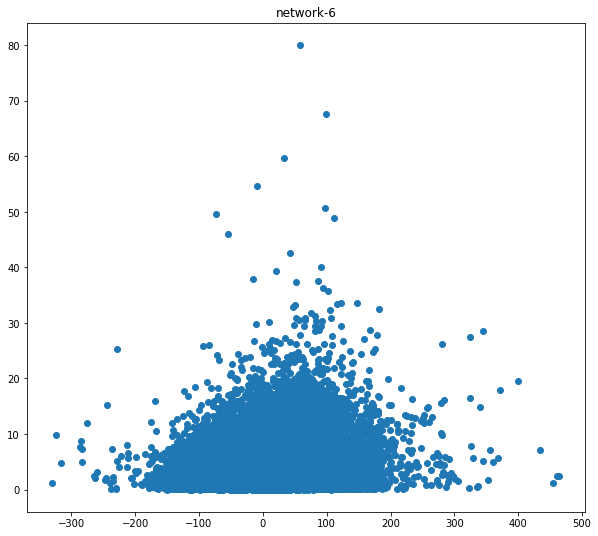

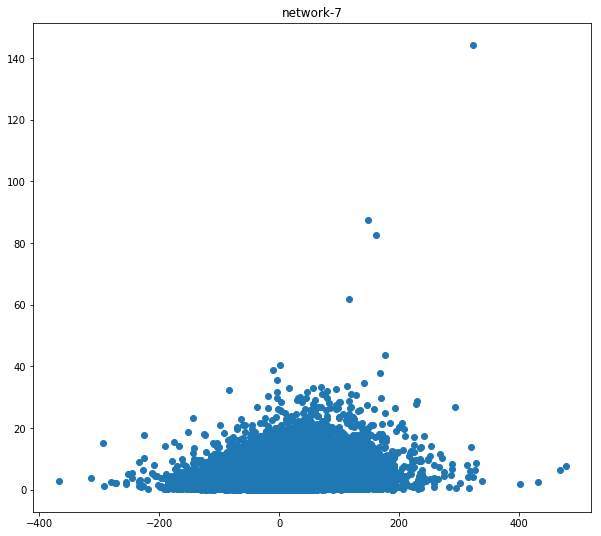

In [24]:
for key in per_net_Eerrors.keys():
    fig, ax = plt.subplots(figsize=(10,9))
    ax.set_title(key)
    plt.scatter(per_net_Eerrors[key][0],np.abs(per_net_Eerrors[key][1]-per_net_Eerrors[key][0]))
    plt.show()